<img src="https://github.com/KartikNW/MSDS_458_Public/blob/main/images2/NorthwesternHeader.png?raw=1" />

# Assignment 01 – Diamonds Regression with SMOTE

In this assignment, you will extend the basic diamond price prediction model by addressing **class imbalance** in the price distribution using **SMOTE (Synthetic Minority Over-sampling Technique)**.

## What You'll Learn

This notebook demonstrates an advanced approach to regression problems where certain price ranges are underrepresented in the data. You will:

- Create **price tiers** to categorize diamonds into low, medium, and high price ranges
- Apply **SMOTE** to generate synthetic samples for underrepresented price ranges, creating a more balanced training dataset
- Train a neural network on the balanced data to improve predictions across all price ranges
- Compare model performance with and without SMOTE to understand its impact on prediction accuracy

## Key Difference from Basic Regression

Unlike the standard regression approach in `Assignment_01_diamonds_regression`, this notebook treats price prediction as a **stratified regression problem**. By balancing the training data across price tiers, you can potentially improve the model's ability to predict prices for expensive diamonds, which are naturally less common in the dataset.

> **Note:** This is an experimental approach. You will evaluate whether SMOTE improves overall model performance compared to training on the original imbalanced data.

## Import Required Libraries

In this section, we import the essential Python libraries needed for data manipulation, visualization, and building deep learning models.  

- **Pandas** and **NumPy** are used for data handling and numerical computations.  
- **Matplotlib** and **Seaborn** help visualize feature distributions and model performance.  
- **TensorFlow** and **Keras** are used to construct, train, and evaluate the neural network regression model.  
- A private helper module, **`diamonds_utils.py`**, is also imported. This module contains utility functions that simplify repetitive tasks such as data preprocessing, visualization, and evaluation—making the notebook cleaner and easier to follow.  

> ⚠️ **Note:** The `diamonds_utils.py` file is not part of the standard library and must be downloaded from the course GitHub repository before running this notebook.





In [ ]:
import os, sys, importlib.util, urllib.request

IN_COLAB = 'google.colab' in sys.modules
UTILS_PATH = 'diamonds_utils.py'

def fetch_github_raw(user, repo, branch, file_path, local_path):
    url = f"https://raw.githubusercontent.com/{user}/{repo}/{branch}/{file_path}"
    urllib.request.urlretrieve(url, local_path)
    print(f"Fetched {file_path} from branch '{branch}'.")

if IN_COLAB and not os.path.exists(UTILS_PATH):
    fetch_github_raw("kartikNW", "MSDS_458_Public", "future", 
                     "MSDS458_Assignment_01/diamonds_utils.py", UTILS_PATH)
else:
    print("Using local diamonds_utils.py")

Using local diamonds_utils.py


In [2]:
# Set the environment variable to disable GPU
os.environ['DIAMONDS_DISABLE_GPU'] = '1'

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from packaging import version

from diamonds_utils import (
    load_data,
    display_data_info,
    analyze_categorical_variables,
    analyze_price_distribution,
    analyze_carat_price_relationship,
    analyze_cut_impact,
    analyze_correlations,
    create_price_tiers,
    prepare_data,
    train_model,
    plot_training_history,
    plot_percentage_error_by_price,
    evaluate_model,
    residual_plot,
    remove_specific_outliers,
    apply_smote
    
)

/Users/kartikshridhar/gitrepos/personal/MSDS_458_Collab/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Version Requirements

This assignment requires recent versions of **Python** and **TensorFlow/Keras** to ensure compatibility with the neural network code.  

| Library | Minimum Version | Purpose |
|----------|------------------|----------|
| Python | 3.10 | Core language |
| TensorFlow / Keras | 2.15 | Deep learning framework |

If you're running this notebook locally, you can verify your setup using the code cell below.


In [4]:
print("Python version:", sys.version.split()[0])
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

# Minimum version requirements
min_versions = {
    "Python": "3.10",
    "TensorFlow": "2.15",
    "Keras": "3.0",
}

def check_version(name, current, minimum):
    if version.parse(current) < version.parse(minimum):
        print(f"⚠️ {name} version {current} < required {minimum}. Please upgrade.")

check_version("Python", sys.version.split()[0], min_versions["Python"])
check_version("TensorFlow", tf.__version__, min_versions["TensorFlow"])
check_version("Keras", tf.keras.__version__, min_versions["Keras"])

Python version: 3.9.6
TensorFlow version: 2.19.0
Keras version: 3.10.0
⚠️ Python version 3.9.6 < required 3.10. Please upgrade.


## Load and Display Data

First, you will load the dataset and display its basic information. This is the same dataset used in the basic regression assignment, containing **53,940 diamonds** with features like carat, cut, color, clarity, and price.

In this notebook, you will focus on how the **distribution of prices** affects model training, particularly noting that high-priced diamonds are much less common than lower-priced ones.

In [5]:
# Load the dataset
diamonds = load_data()

# Display basic information
display_data_info(diamonds)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB
None

First 5 rows of the dataset:
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I   

## Exploratory Data Analysis (EDA)

You will perform a focused exploratory analysis to understand the **price imbalance problem** that SMOTE will address. Unlike the comprehensive EDA in the basic regression assignment, here you'll concentrate on visualizations that reveal distribution issues.

As you review these visualizations, consider:
- Which price ranges have the fewest samples?
- How might this imbalance affect a model's ability to predict expensive diamond prices?
- Could the model be biased toward predicting prices in the most common ranges?

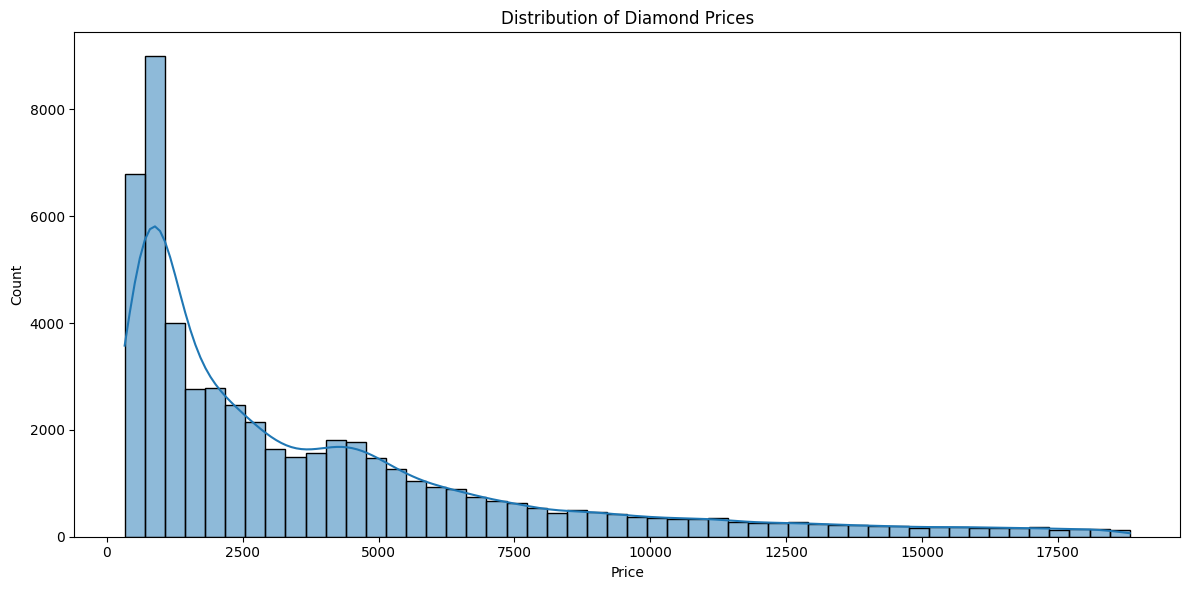


Price Statistics:
count    53940.000000
mean      3932.799722
std       3989.439738
min        326.000000
25%        950.000000
50%       2401.000000
75%       5324.250000
max      18823.000000
Name: price, dtype: float64


In [6]:
# Analyze price distribution - KEY for understanding SMOTE's purpose
analyze_price_distribution(diamonds)

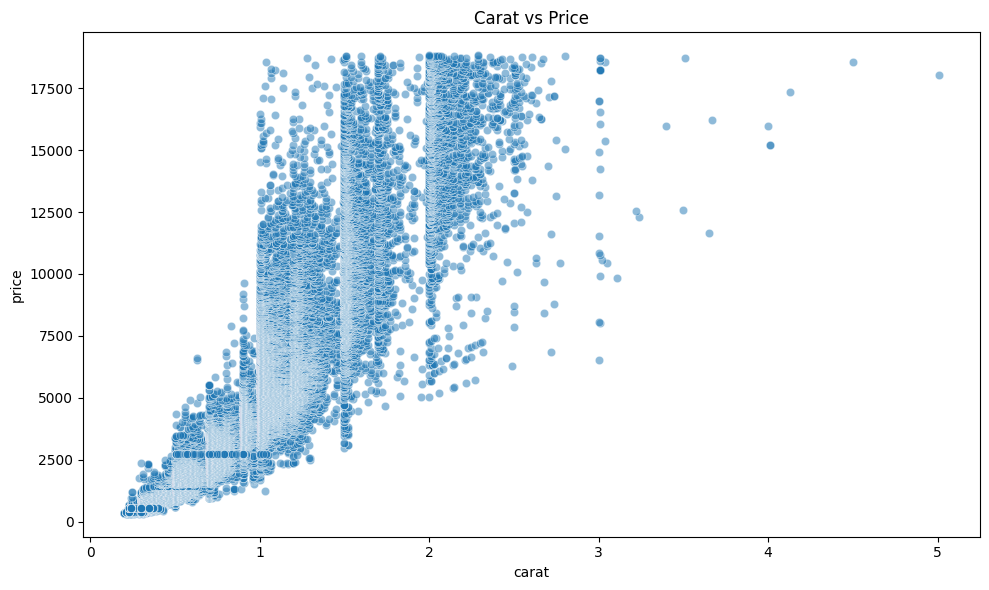


Correlation between carat and price: 0.922


In [7]:
# Analyze carat-price relationship - shows natural scarcity of expensive diamonds
analyze_carat_price_relationship(diamonds)

### Optional: Additional EDA

If you want to review other feature relationships (cut, color, clarity, correlations), you can uncomment and run the cells below. However, these are less critical for understanding the SMOTE approach.

In [8]:
# # Uncomment if you want to explore categorical variables
# # analyze_categorical_variables(diamonds)

In [9]:
# # Uncomment if you want to explore cut impact
# # analyze_cut_impact(diamonds)

In [10]:
# # Uncomment if you want to explore correlations
# # analyze_correlations(diamonds)

## Remove Outliers

In [11]:
# Remove outliers
diamonds = remove_specific_outliers(diamonds)

Before removing specific outliers: (53940, 10)
After removing specific outliers: (53916, 10)
Removed 24 rows (0.04% of data)

Removal Summary:
- Zero dimensions (x=0, y=0, z=0): 35 rows
- Table = 95: 1 rows
- Y = 31.8: 1 rows
- Y = 58.9: 1 rows
- Z = 31.8: 1 rows


## Applying SMOTE to Address Price Imbalance

In this section, you will apply **SMOTE (Synthetic Minority Over-sampling Technique)** to create a more balanced training dataset. SMOTE generates synthetic samples for underrepresented price ranges, helping the model learn patterns across all price tiers rather than being dominated by common lower-priced diamonds.

### The Process

1. **Create Price Tiers**: You will categorize diamonds into low, medium, and high price ranges using thresholds
2. **Prepare Data**: Split and preprocess the data, encoding the price tiers as categorical targets
3. **Apply SMOTE**: Generate synthetic samples to balance the representation across price tiers
4. **Extract Price Values**: After balancing, extract the actual price values for regression training

> **Experiment**: Try adjusting the `low_threshold` and `high_threshold` values in `create_price_tiers()` to see how different tier definitions affect the results. Also experiment with the `k_neighbors` parameter in SMOTE.

In [12]:
# Create price tiers (Experiment with different thresholds)
diamonds = create_price_tiers(diamonds, low_threshold=5000, high_threshold=10000)

### Prepare and Balance the Data

Now you will prepare the features and apply SMOTE. Notice that you're temporarily treating this as a classification problem (using price tiers) to apply SMOTE, but you'll ultimately use the continuous price values for regression.

In [13]:
numerical_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
categorical_features = ['cut', 'color', 'clarity']

# Prepare data for model training
X_train, X_test, y_train, y_test, preprocessor = prepare_data(
    diamonds, 
    numerical_features, 
    categorical_features, 
    target='price_tier', 
    encode_target=True
)

In [14]:
# Apply SMOTE to balance the dataset across price tiers
X_train_balanced, y_train_balanced = apply_smote(
    X_train, 
    y_train, 
    k_neighbors=5, 
    random_state=42
)

/Users/kartikshridhar/gitrepos/personal/MSDS_458_Collab/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Original training data shape: (43132, 24)
Balanced training data shape: (93939, 24)

Class distribution after SMOTE:
0
0    31313
1    31313
2    31313
Name: count, dtype: int64


### Extract Price Values for Regression

After SMOTE creates synthetic samples based on price tiers, you need to extract the actual price values (stored in the last column) to use as your regression target. The test set is also restructured to match.

In [15]:
# Remove price from training data and add to target variable
y_train_balanced = X_train_balanced[:, 23]
X_train_balanced = X_train_balanced[:, :-1]

y_test = X_test[:, 23]
X_test = X_test[:, :-1]

### Visualize the Balanced Price Distribution

Compare this distribution to the original price distribution you saw earlier. Notice how SMOTE has increased the representation of higher-priced diamonds in the training set.

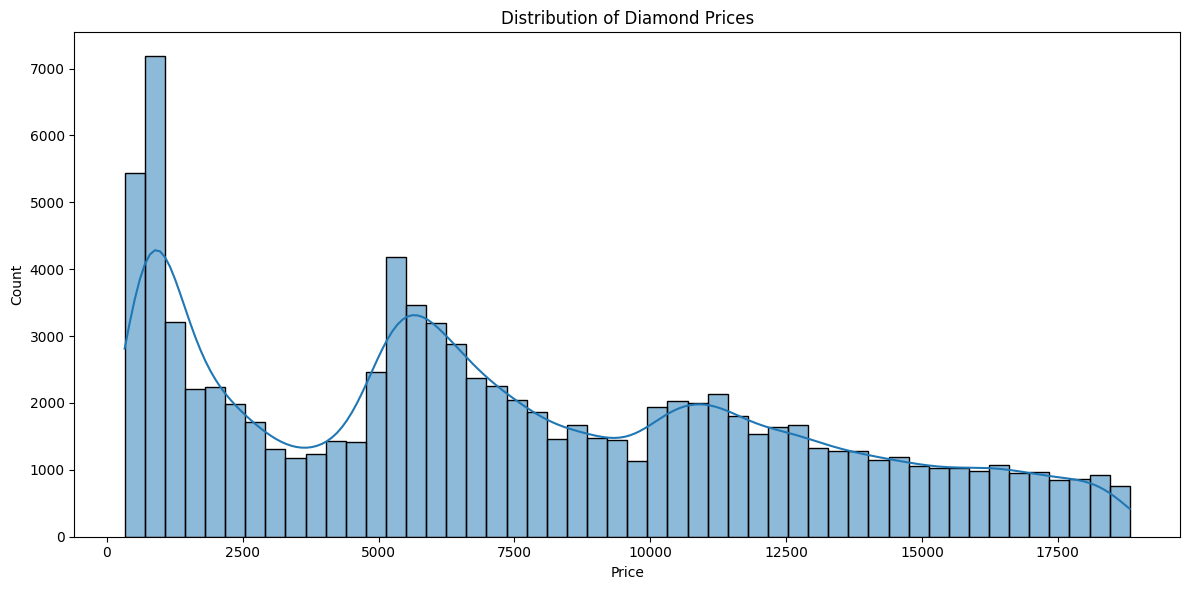


Price Statistics:
count    93939.000000
mean      7489.561765
std       5141.857162
min        326.000000
25%       2815.000000
50%       6640.213827
75%      11400.738618
max      18823.000000
Name: price, dtype: float64


In [16]:
# Analyze the distribution of the balanced price
analyze_price_distribution(pd.DataFrame(y_train_balanced, columns=['price']))

## Model Training and Evaluation

Now you will train a neural network on the **balanced dataset** and evaluate its performance. The key question: Does training on SMOTE-balanced data improve predictions, especially for expensive diamonds?

### What to Look For

As you train and evaluate this model, pay attention to:
- Does the model perform better on high-priced diamonds compared to the original model?
- How does the overall MAE and R² compare to the baseline regression model?
- Are the residuals more evenly distributed across all price ranges?

> **Compare Your Results**: After completing this notebook, compare the evaluation metrics and visualizations with those from `Assignment_01_diamonds_regression`. Which approach works better? Why might that be?

In [17]:
# Train model on balanced data
print("Training model on SMOTE-balanced data...")
model_smote, history_smote = train_model(
    X_train_balanced, y_train_balanced,
    patience=3,
    epochs=50
)

Training model on SMOTE-balanced data...
Epoch 1/50
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 1s 439us/step - loss: 21509364.0000 - mae: 2599.4878 - mape: 38.6125 - val_loss: 1176433.7500 - val_mae: 731.5938 - val_mape: 10.6222
Epoch 2/50
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step - loss: 1447267.6250 - mae: 724.1638 - mape: 12.2966 - val_loss: 918984.3125 - val_mae: 633.0804 - val_mape: 9.1521
Epoch 3/50
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 1s 403us/step - loss: 1247615.1250 - mae: 661.7883 - mape: 9.8436 - val_loss: 779351.2500 - val_mae: 591.3063 - val_mape: 8.5175
Epoch 4/50
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - loss: 1119833.0000 - mae: 633.3811 - mape: 9.3951 - val_loss: 615105.3750 - val_mae: 547.1167 - val_mape: 7.9275
Epoch 5/50
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step - loss: 1013808.1875 - mae: 611.2410 - mape: 9.2951 - val_loss: 573304.1250 - val_mae: 525.5140 - val_mape: 7.5334
Epoch 6/50
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 1s 405us/step - loss: 908708.3750 - mae: 590.2861 - mape

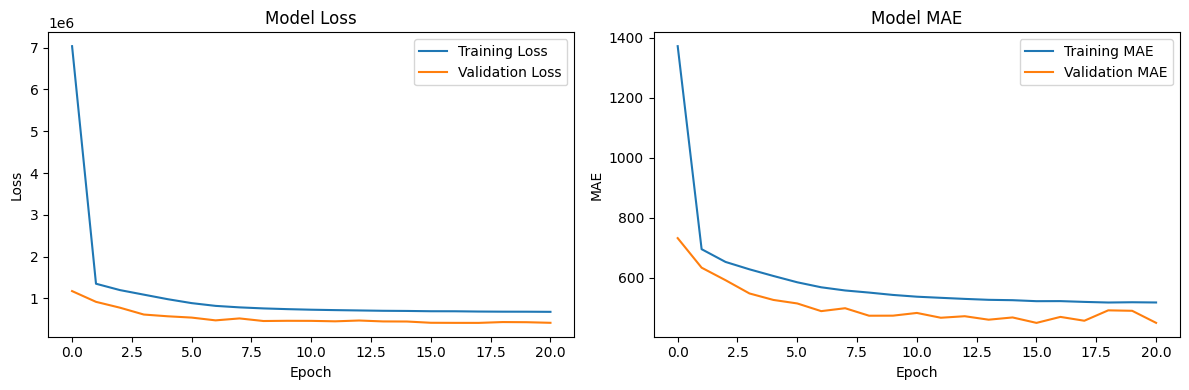

In [18]:
# Plot training history
plot_training_history(history_smote)

### Model Evaluation

You will now evaluate the model on the test set (which is NOT balanced - it contains the original price distribution). This tests whether the model generalizes well to real-world data after training on balanced data.

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step - loss: 288433.9688 - mae: 300.7683 - mape: 9.3935

Test MAE: $298.16
Test MAPE: 9.36%
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
R-squared Score: 0.9814


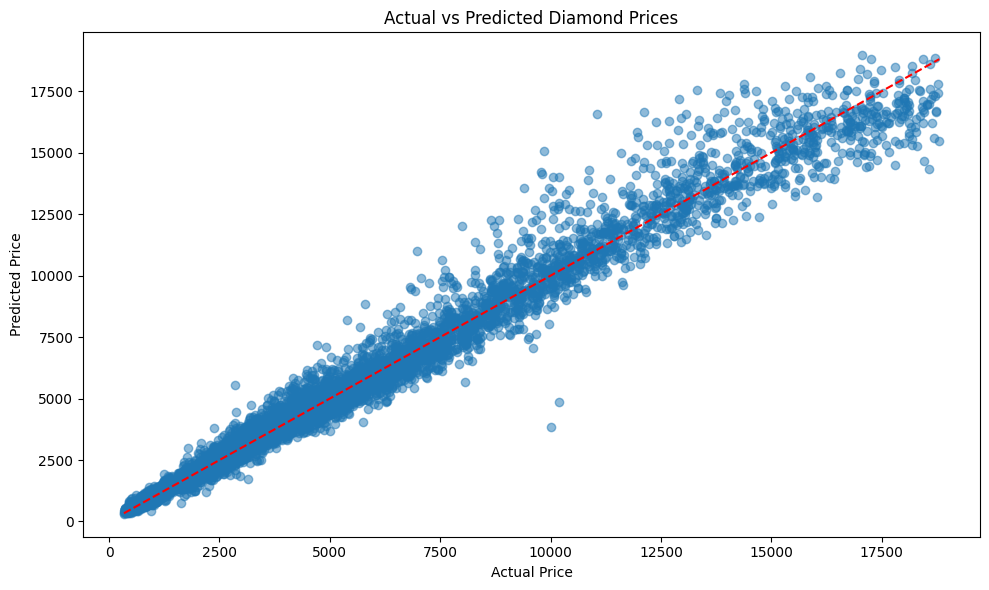

In [19]:
# Evaluate model on original test set
y_pred_smote = evaluate_model(model_smote, X_test, y_test)

### Analyze Error by Price Range

This visualization is particularly important for the SMOTE approach. You want to see if the percentage error is more consistent across different price ranges compared to the baseline model.

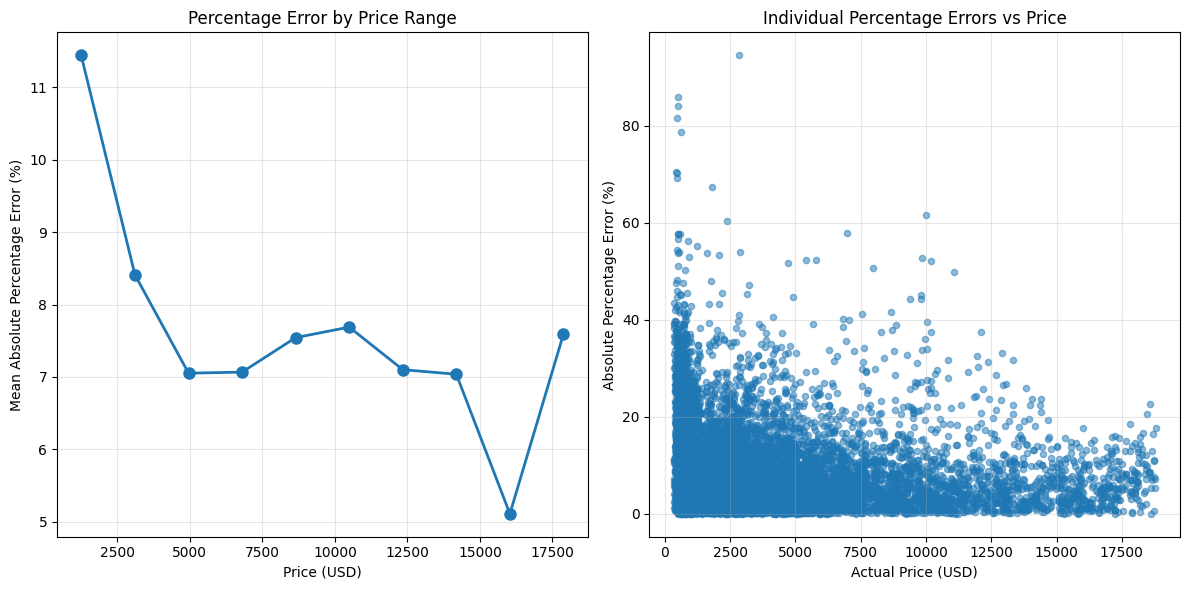


Percentage Error Summary:
Overall MAPE: 9.36%
MAPE for diamonds < $5,000: 10.23%
MAPE for diamonds $5,000-$10,000: 7.10%
MAPE for diamonds > $10,000: 6.81%


In [20]:
# Plot percentage error by price
percentage_errors, bin_centers_actual, bin_errors = plot_percentage_error_by_price(y_test, y_pred_smote)

### Residual Analysis

Examine the residual plot to see if errors are evenly distributed across all predicted prices. Compare this with the residual plot from the basic regression model - are there noticeable improvements?

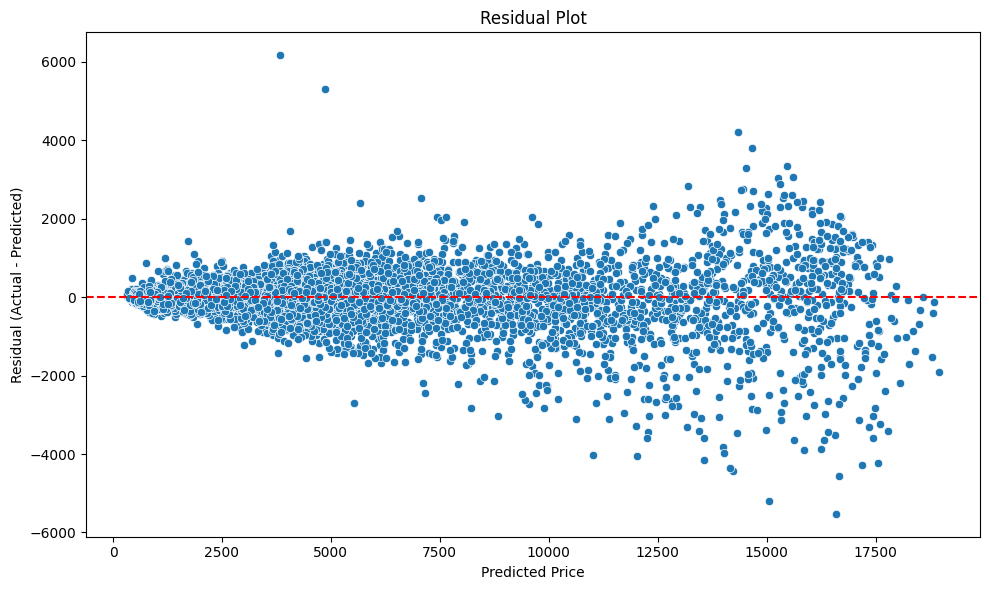

In [21]:
# Create residual plot
residual_plot(y_test, y_pred_smote)

## Reflection Questions

After completing both notebooks, consider these questions:

1. **Performance Comparison**: Did SMOTE improve overall prediction accuracy (MAE, R²)? Or did it trade overall accuracy for better performance on expensive diamonds?
2. **Error Distribution**: Are errors more evenly distributed across price ranges with SMOTE, or is the original model better?
3. **Practical Application**: For a jewelry business, which model would be more valuable - one with lower overall error, or one that predicts expensive diamonds more accurately?
4. **Trade-offs**: What are the downsides of using SMOTE for this regression problem?

> **Extension**: Try training a model with different SMOTE parameters (k_neighbors, different price tier thresholds) to see if you can find a better balance between overall accuracy and performance on rare, expensive diamonds.